工学院経営工学系経営工学コース\
20M14894\
笛木正雄

## Problem3

Text(0, 0.5, 'x2')

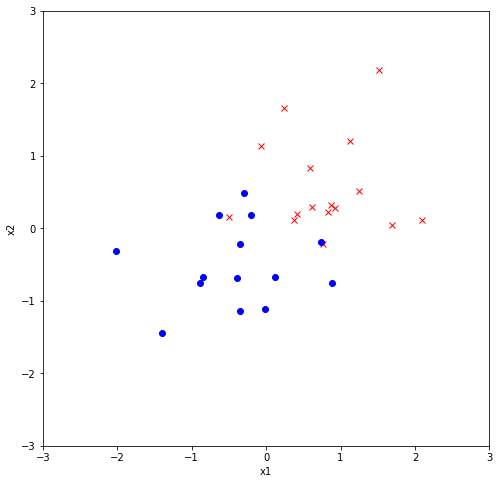

In [ ]:
# dataset 2
np.random.seed(1)
n = 30
omega = np.random.randn()
noise = 0.8 * np.random.randn(n)

x_d2 = np.random.randn(n, 2) + 0
y_d2 = 2 * (omega * x_d2[:,0] + x_d2[:,1] + noise > 0) - 1

plt.figure(figsize=(8, 8))
plt.plot(np.extract(y_d2>0,x_d2[:,0]),np.extract(y_d2>0,x_d2[:,1]), 'x', c='red')
plt.plot(np.extract(y_d2<0,x_d2[:,0]),np.extract(y_d2<0,x_d2[:,1]), 'o', c='blue')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('x1')
plt.ylabel('x2')

In [ ]:
class SVM:
    def __init__(self, lam):
        self.lam = lam

    def fit(self, x, y, eta):
        n = x.shape[0]
        self.alpha = np.random.rand(n)
        K = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                K[i][j] = y[i] * y[j] * x[i] @ x[j]

        while True:
            self.alpha = np.clip(self.alpha - eta * ((1 / (2 * self.lam)) * K @ self.alpha - 1), a_min=0, a_max=1)
            score_D = -(1 / (4 * self.lam)) * self.alpha @ K @ self.alpha + sum(self.alpha)

            self.w = (1 / (2 * self.lam)) * sum([self.alpha[i] * y[i] * x[i] for i in range(n)])
            score_P = sum([np.max([0, 1 - y[i] * self.w @ x[i]]) for i in range(n)])+ self.lam * self.w @ self.w

            # print(score_P - score_D)
            if abs(score_P - score_D) <= 1e-5:
                break
    
    def predict(self, x):
        return np.array([2 * (self.w @ xi >= 0) - 1 for xi in x])

In [ ]:
model = SVM(lam=3)
model.fit(x_d2, y_d2, eta=0.1)

Text(0, 0.5, 'x2')

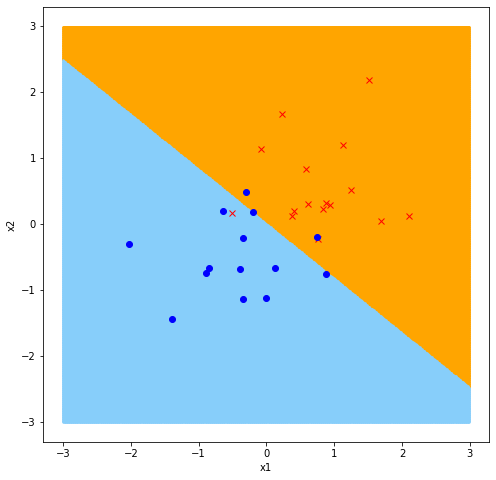

In [ ]:
plt.figure(figsize=(8, 8))
x1 = np.arange(-3, 3, 0.01)
x2 = np.arange(-3, 3, 0.01)
xx, yy = np.meshgrid(x1, x2)
xx = xx.flatten()
yy = yy.flatten()
xy = np.c_[xx, yy]

y_hat = model.predict(xy)

plt.scatter(xy[y_hat==1].T[0], xy[y_hat==1].T[1], c='orange', s=2)
plt.scatter(xy[y_hat==-1].T[0], xy[y_hat==-1].T[1], c='lightskyblue', s=2)

plt.plot(np.extract(y_d2>0,x_d2[:,0]),np.extract(y_d2>0,x_d2[:,1]), 'x', c='red')
plt.plot(np.extract(y_d2<0,x_d2[:,0]),np.extract(y_d2<0,x_d2[:,1]), 'o', c='blue')
plt.xlabel('x1')
plt.ylabel('x2')

## Problem4

In [ ]:
# dataset 4
np.random.seed(0)
n = 200
x_d4 = 3 * (np.random.rand(n, 4) - 0.5)
y_d4 = (2 * x_d4[:, 0] - 1 * x_d4[:,1] + 0.5 + 0.5 * np.random.randn(n)) > 0
y_d4 = 2 * y_d4 -1

In [ ]:
x_d4.shape, y_d4.shape

((200, 4), (200,))

### cvxpy

In [ ]:
def L1_hinge(x, y, lam):
    n = x.shape[0]
    d = x.shape[1]

    # 変数設定
    xi = cv.Variable((n, 1))
    w = cv.Variable((d, 1))

    # 目的関数
    obj_fn = cv.sum(xi) + lam * cv.norm(w, 1)
    objective = cv.Minimize(obj_fn)

    # 制約式
    constraints = [xi >= np.zeros((n, 1))] + [xi[i] >= 1 - y[i] * w.T@x[i] for i in range(n)]

    prob = cv.Problem(objective, constraints)
    result = prob.solve(solver=cv.CVXOPT) 
    return np.ravel(w.value)

In [ ]:
w = L1_hinge(x_d4, y_d4, lam=2)
w

array([ 2.3415316 , -0.94152215, -0.16324726, -0.15151673])

In [ ]:
y_hat_1 = np.array([2 * (w.T @ x_d4[i] >= 0) - 1 for i in range(n)])
(sum(y_d4 == y_hat_1) / n) * 100

86.5

In [ ]:
def LP_L1_hinge(x, y, lam):
    lam = 2
    n = x.shape[0]
    d = x.shape[1]
    c = np.array([1]*n + [lam]*d + [0]*d).reshape(n+d+d, 1)
    z = cv.Variable((n+d+d, 1))

    A1 = np.hstack([-np.eye(n), np.zeros((n, d+d))])
    A2 = np.hstack([-np.eye(n), np.zeros((n, d)), np.vstack([-y[i] * x[i] for i in range(n)])])
    A3 = np.hstack([np.zeros((d, n)), -np.eye(d), -np.eye(d)])
    A4 = np.hstack([np.zeros((d, n)), -np.eye(d), np.eye(d)])
    A5 = np.hstack([np.zeros((d, n)), -np.eye(d), np.zeros((d, d))])
    A = np.vstack([A1, A2, A3, A4, A5])

    b = np.array([0]*n + [-1]*n + [0]*d + [0]*d + [0]*d).reshape(n+n+d+d+d, 1)

    obj_fn = c.T @ z
    objective = cv.Minimize(obj_fn)

    constraints = [A @ z <= b]

    prob = cv.Problem(objective, constraints)
    result = prob.solve(solver=cv.CVXOPT)

    w = np.ravel(z.value[-d:])
    return w

In [ ]:
w = LP_L1_hinge(x_d4, y_d4, lam=2)
w

array([ 2.34153193, -0.94152256, -0.16324716, -0.15151678])

In [ ]:
y_hat_2 = np.array([2 * (w.T @ x_d4[i] >= 0) - 1 for i in range(n)])
(sum(y_d4 == y_hat_2) / n) * 100

86.5

### subgradient method

In [ ]:
def subgrad_loss(x, y, w):
    ywx = y * w @ x
    if ywx > 1:
        return np.zeros((w.shape))
    elif ywx == 1:
        # e = np.random.rand()
        e = 1
        return -e * y * x
    else:
        return -y * x

def subgrad_reg(lam, w):
    if w > 0:
        return lam
    elif w == 0:
        # e = 2 * np.random.rand() - 1
        e = 1
        return e * lam
    else:
        return -lam

def subgrad(x, y, eta, T=10000):
    eta = 0.1
    n = x_d4.shape[0]
    w = np.random.rand(4)
    lam = 2

    loss_hist = []

    for t in range(T):
        g_loss = np.sum(np.array([subgrad_loss(x_d4[i], y_d4[i], w) for i in range(n)]), axis=0)
        g_reg = np.array([subgrad_reg(lam, w[i]) for i in range(len(w))])

        w = w - eta * (1 / (t+1)**(1/2)) * (g_loss + g_reg)
    return w

In [ ]:
subgrad(x_d4, y_d4, eta=0.1)

array([ 2.34512617, -0.94749772, -0.1620871 , -0.15158547])

In [ ]:
eta = 0.1
n = x_d4.shape[0]
w = np.random.rand(4)
lam = 2

loss_hist = []

for t in range(10000):
    g_loss = np.sum(np.array([subgrad_loss(x_d4[i], y_d4[i], w) for i in range(n)]), axis=0)
    g_reg = np.array([subgrad_reg(lam, w[i]) for i in range(len(w))])

    w = w - eta * (1 / (t+1)**(1/2)) * (g_loss + g_reg)

    loss = sum([max(0, 1 - y_d4[i]*w@x_d4[i]) for i in range(n)]) + lam * sum(np.abs(w))
    loss_hist.append(loss)
    
    if t % 1000 == 0:
        print(w)
w

[ 7.38944605 -5.39348232 -1.34230842 -6.92834395]
[ 2.35112525 -0.95651701 -0.16065613 -0.15562833]
[ 2.34817336 -0.95463828 -0.16193161 -0.15383016]
[ 2.3480498  -0.94964414 -0.1605165  -0.15413416]
[ 2.3465301  -0.95104104 -0.16216544 -0.14859909]
[ 2.34592788 -0.9495701  -0.16125026 -0.15202335]
[ 2.34605611 -0.94818433 -0.16127191 -0.15288473]
[ 2.34526947 -0.94783092 -0.16254114 -0.15247135]
[ 2.34479182 -0.94821284 -0.16295867 -0.15221855]
[ 2.3459473  -0.94695815 -0.16262366 -0.15188905]


array([ 2.34533179, -0.94603947, -0.16135349, -0.15243742])

Text(0, 0.5, 'loss')

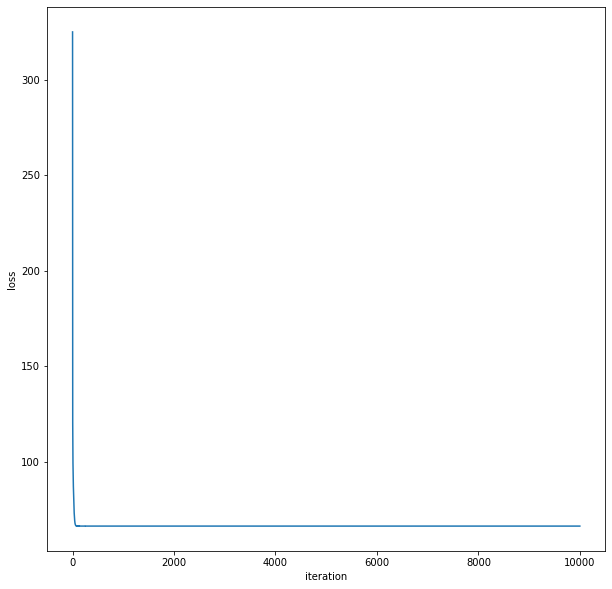

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(loss_hist)
plt.xlabel('iteration')
plt.ylabel('loss')

## Problem5

Text(0, 0.5, 'x2')

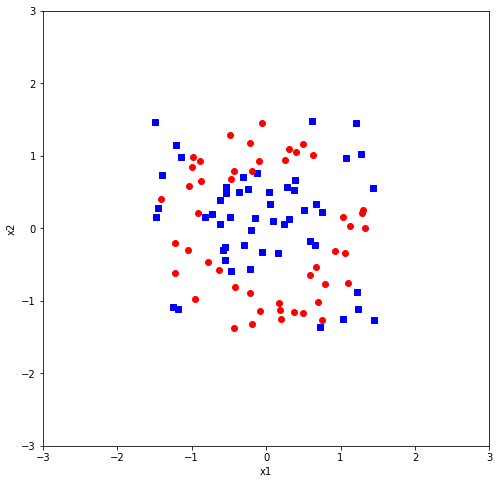

In [ ]:
# データセット
# dataset 1
np.random.seed(123)
n = 100
x_d1 = 3 * (np.random.rand(n, 2)-0.5)
radius = x_d1[:,0]**2 + x_d1[:,1]**2
y_d1 = (radius > 0.7 + 0.1 * np.random.randn(n)) &( radius < 2.2 + 0.1 * np.random.randn(n))
y_d1 = 2 * y_d1 -1

plt.figure(figsize=(8, 8))
plt.plot(x_d1[y_d1 < 0, 0],  x_d1[y_d1 < 0, 1], 'bs')
plt.plot(x_d1[y_d1 > 0, 0],  x_d1[y_d1 > 0, 1], 'ro')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('x1')
plt.ylabel('x2')

In [ ]:
x_d1.shape, y_d1.shape

((100, 2), (100,))

In [ ]:
model = SVM(lam=3)
model.fit(x_d1, y_d1, eta=0.1)

Text(0, 0.5, 'x2')

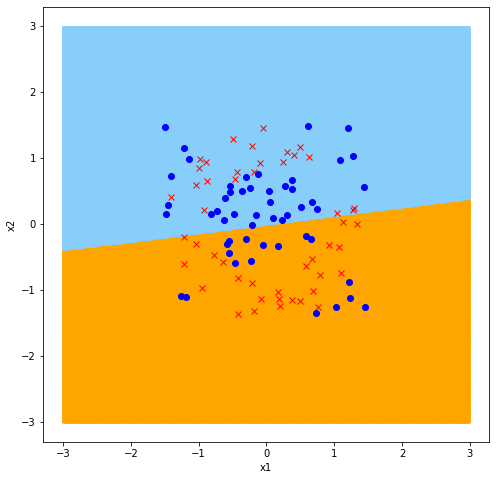

In [ ]:
plt.figure(figsize=(8, 8))
x1 = np.arange(-3, 3, 0.01)
x2 = np.arange(-3, 3, 0.01)
xx, yy = np.meshgrid(x1, x2)
xx = xx.flatten()
yy = yy.flatten()
xy = np.c_[xx, yy]

y_hat = model.predict(xy)

plt.scatter(xy[y_hat==1].T[0], xy[y_hat==1].T[1], c='orange', s=2)
plt.scatter(xy[y_hat==-1].T[0], xy[y_hat==-1].T[1], c='lightskyblue', s=2)

plt.plot(np.extract(y_d1>0,x_d1[:,0]),np.extract(y_d1>0,x_d1[:,1]), 'x', c='red')
plt.plot(np.extract(y_d1<0,x_d1[:,0]),np.extract(y_d1<0,x_d1[:,1]), 'o', c='blue')
plt.xlabel('x1')
plt.ylabel('x2')

In [ ]:
class GausianKernel:
    def __init__(self, x_all, alpha, d_tilda):
        self.alpha = alpha
        # 使用するデータをランダム抽出
        self.x_use_index = np.random.choice(np.array(range(len(x_all))), d_tilda, replace=False)
        self.x_d_tilda = x_all[self.x_use_index]
        

    def __call__(self, input_x_vec):
        return np.array([np.exp(-self.alpha * (np.linalg.norm(x_vec - self.x_d_tilda, ord=2, axis=1)**2)) for x_vec in input_x_vec])

In [ ]:
gausian_kernel = GausianKernel(x_d1, alpha=3, d_tilda=90)
x_kernel = gausian_kernel(x_d1)
model = SVM(lam=1)
model.fit(x_kernel, y_d1, eta=0.01)

Text(0, 0.5, 'x2')

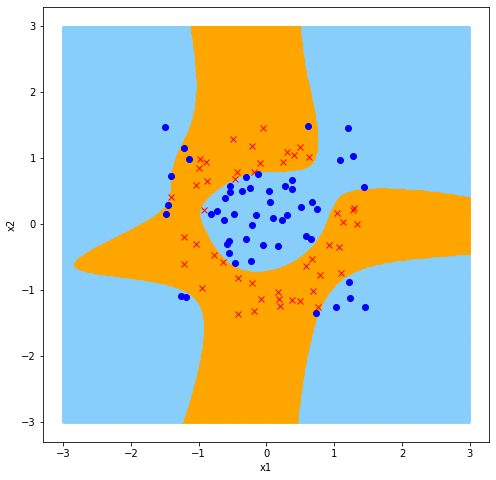

In [ ]:
plt.figure(figsize=(8, 8))
x1 = np.arange(-3, 3, 0.01)
x2 = np.arange(-3, 3, 0.01)
xx, yy = np.meshgrid(x1, x2)
xx = xx.flatten()
yy = yy.flatten()
xy = np.c_[xx, yy]

xy_kernel = gausian_kernel(xy)
y_hat = model.predict(xy_kernel)
y_hat = model.predict(xy_kernel)

plt.scatter(xy[y_hat==1].T[0], xy[y_hat==1].T[1], c='orange', s=2)
plt.scatter(xy[y_hat==-1].T[0], xy[y_hat==-1].T[1], c='lightskyblue', s=2)
plt.plot(np.extract(y_d1>0,x_d1[:,0]),np.extract(y_d1>0,x_d1[:,1]), 'x', c='red')
plt.plot(np.extract(y_d1<0,x_d1[:,0]),np.extract(y_d1<0,x_d1[:,1]), 'o', c='blue')
plt.xlabel('x1')
plt.ylabel('x2')

### 性能比較

Text(0, 0.5, 'x2')

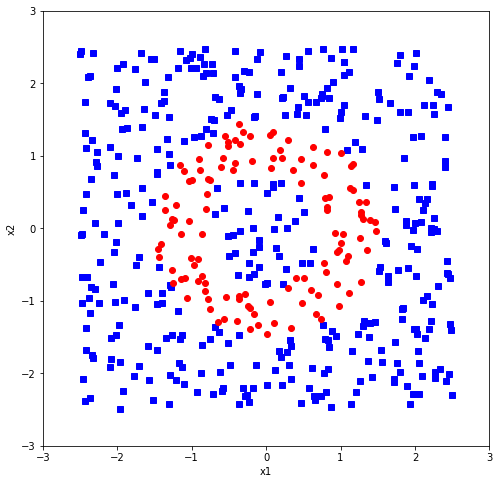

In [ ]:
# dataset 1

def make_dataset(n):
    np.random.seed(123)
    x_d1 = 5 * (np.random.rand(n, 2)-0.5)
    radius = x_d1[:,0]**2 + x_d1[:,1]**2
    y_d1 = (radius > 0.7 + 0.1 * np.random.randn(n)) &( radius < 2.2 + 0.1 * np.random.randn(n))
    y_d1 = 2 * y_d1 -1

    return x_d1, y_d1

x_d1, y_d1 = make_dataset(n=500)

plt.figure(figsize=(8, 8))
plt.plot(x_d1[y_d1 < 0, 0],  x_d1[y_d1 < 0, 1], 'bs')
plt.plot(x_d1[y_d1 > 0, 0],  x_d1[y_d1 > 0, 1], 'ro')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('x1')
plt.ylabel('x2')

In [ ]:
# テストデータと学習データに分ける
def train_test_split(x, y):
    train_data_index = np.random.choice(np.arange(x.shape[0]), int(x.shape[0]*0.8), replace=False)
    test_data_index = np.array(list(set(np.arange(x.shape[0])) - set(train_data_index)))

    train_data_x = x[train_data_index]
    train_data_y = y[train_data_index]

    test_data_x = x[test_data_index]
    test_data_y = y[test_data_index]

    return train_data_x, train_data_y, test_data_x, test_data_y

train_data_x, train_data_y, test_data_x, test_data_y = train_test_split(x_d1, y_d1)

Text(0, 0.5, 'x2')

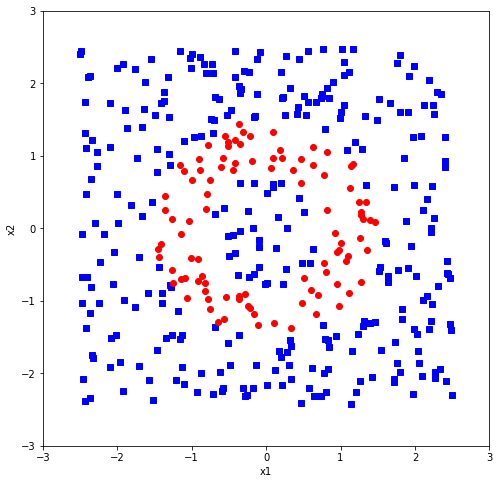

In [ ]:
# dataset 1 train
plt.figure(figsize=(8, 8))
plt.plot(train_data_x[train_data_y < 0, 0], train_data_x[train_data_y < 0, 1], 'bs')
plt.plot(train_data_x[train_data_y > 0, 0], train_data_x[train_data_y > 0, 1], 'ro')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('x1')
plt.ylabel('x2')

In [ ]:
n_list = [50, 100]
alpha_list = [3, 10]
d_tilda_list = [10, 40]

model_dict = dict()
acc_dict = dict()
kernel_dict = dict()
data_dict = dict()
train_test_dict = dict()

for n in n_list:
    for alpha in alpha_list:
        for d_tilda in d_tilda_list:
            x_d1, y_d1 = make_dataset(n)
            data_dict[(n, alpha, d_tilda)] = [x_d1, y_d1]

            train_data_x, train_data_y, test_data_x, test_data_y = train_test_split(x_d1, y_d1)
            train_test_dict[(n, alpha, d_tilda)] = [train_data_x, train_data_y, test_data_x, test_data_y]

            gausian_kernel = GausianKernel(train_data_x, alpha=alpha, d_tilda=d_tilda)
            kernel_dict[(n, alpha, d_tilda)] = gausian_kernel

            model = SVM(lam=3)
            model.fit(gausian_kernel(train_data_x), train_data_y, eta=0.01)

            model_dict[(n, alpha, d_tilda)] = model

            y_hat = model.predict(gausian_kernel(test_data_x))
            acc_dict[(n, alpha, d_tilda)] = sum(y_hat == test_data_y) / len(test_data_y)

            print((n, alpha, d_tilda), acc_dict[(n, alpha, d_tilda)])

(50, 3, 10) 0.5
(50, 3, 40) 0.6
(50, 10, 10) 0.6
(50, 10, 40) 0.8
(100, 3, 10) 0.6
(100, 3, 40) 0.85
(100, 10, 10) 0.65
(100, 10, 40) 0.85


In [ ]:
acc_dict

{(50, 3, 10): 0.5,
 (50, 3, 40): 0.6,
 (50, 10, 10): 0.6,
 (50, 10, 40): 0.8,
 (100, 3, 10): 0.6,
 (100, 3, 40): 0.85,
 (100, 10, 10): 0.65,
 (100, 10, 40): 0.85}

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


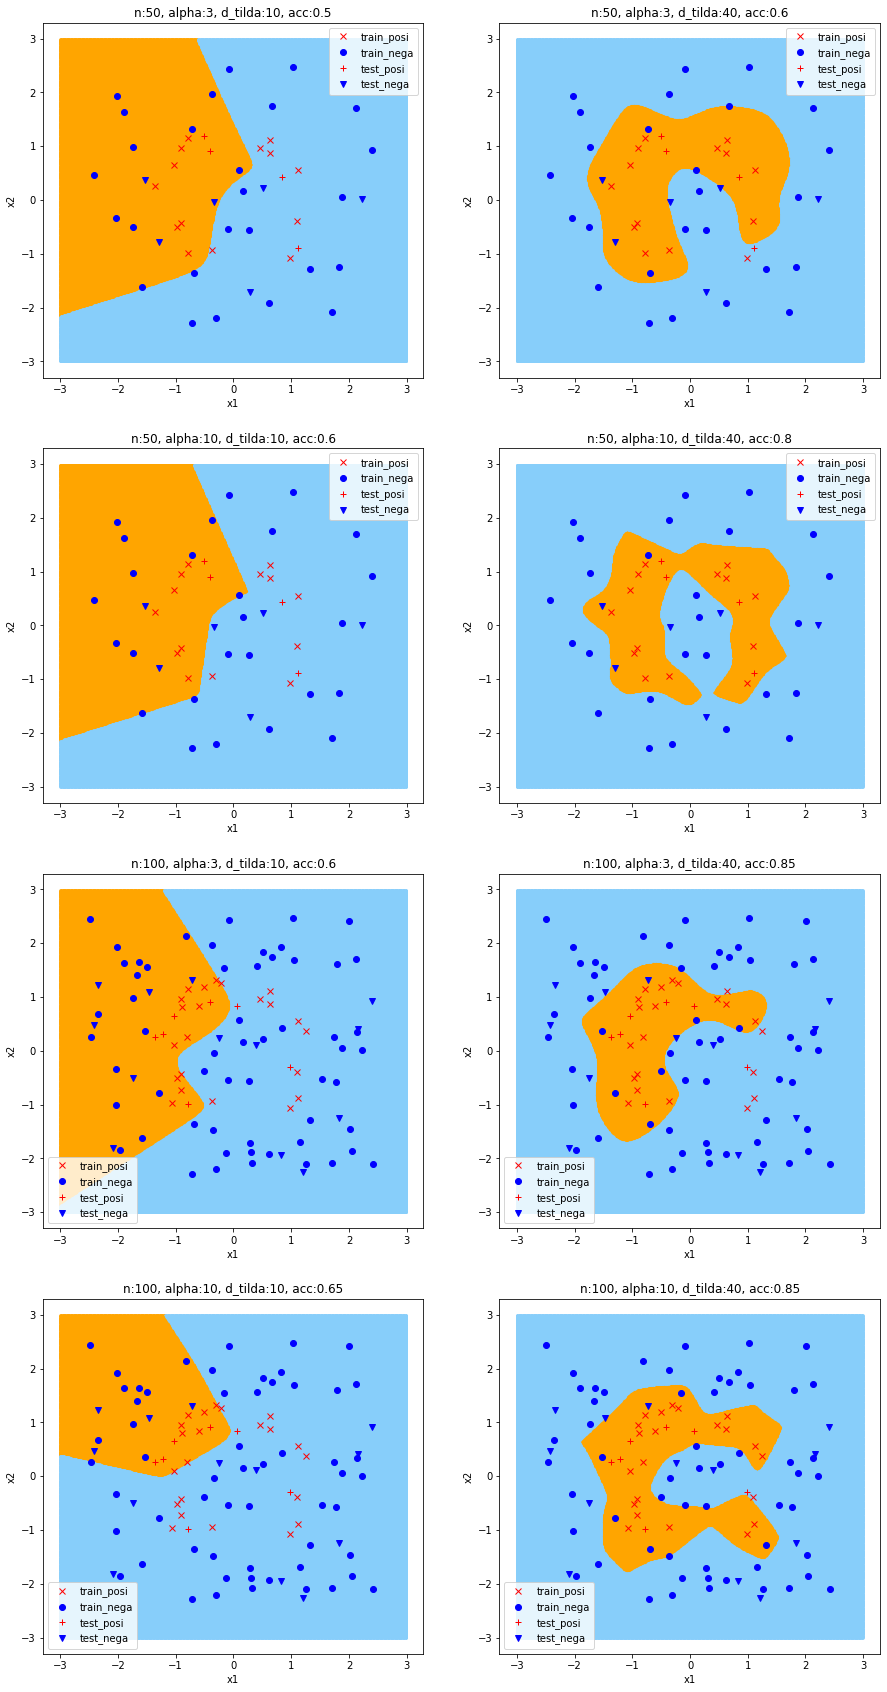

In [ ]:
fig = plt.figure(figsize=(15, 30))
for i, key in enumerate(model_dict.keys()):
    ax = fig.add_subplot(4, 2, i+1)
    x1 = np.arange(-3, 3, 0.01)
    x2 = np.arange(-3, 3, 0.01)
    xx, yy = np.meshgrid(x1, x2)
    xx = xx.flatten()
    yy = yy.flatten()
    xy = np.c_[xx, yy]

    gausian_kernel = kernel_dict[key]
    model = model_dict[key]

    xy_kernel = gausian_kernel(xy)
    y_hat = model.predict(xy_kernel)
    y_hat = model.predict(xy_kernel)

    plt.scatter(xy[y_hat==1].T[0], xy[y_hat==1].T[1], c='orange', s=2)
    plt.scatter(xy[y_hat==-1].T[0], xy[y_hat==-1].T[1], c='lightskyblue', s=2)


    train_data_x, train_data_y, test_data_x, test_data_y = train_test_dict[key]
    plt.plot(np.extract(train_data_y>0, train_data_x[:,0]), np.extract(train_data_y>0, train_data_x[:,1]), 'x', c='red', label='train_posi')
    plt.plot(np.extract(train_data_y<0, train_data_x[:,0]), np.extract(train_data_y<0, train_data_x[:,1]), 'o', c='blue', label='train_nega')

    plt.plot(np.extract(test_data_y>0, test_data_x[:,0]), np.extract(test_data_y>0, test_data_x[:,1]), '+', c='red', label='test_posi')
    plt.plot(np.extract(test_data_y<0, test_data_x[:,0]), np.extract(test_data_y<0, test_data_x[:,1]), 'v', c='blue', label='test_nega')


    plt.xlabel('x1')
    plt.ylabel('x2')

    ax.set_title(f'n:{key[0]}, alpha:{key[1]}, d_tilda:{key[2]}, acc:{acc_dict[key]}')
    ax.legend()